<a href="https://colab.research.google.com/github/sebasesto/CEIA/blob/master/NLP/Sesto_5_Clothing_ecommerce_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 44.7MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head().T

,0,1,2,3,4
Clothing ID,767,1080,1077,1049,847
Age,33,34,60,50,47
Title,NaN,NaN,Some major design flaws,My favorite buy!,Flattering shirt
Review Text,Absolutely wonderful - silky and sexy and comf...,Love this dress! it's sooo pretty. i happene...,I had such high hopes for this dress and reall...,"I love, love, love this jumpsuit. it's fun, fl...",This shirt is very flattering to all due to th...
Rating,4,5,3,5,5
Recommended IND,1,1,0,1,1
Positive Feedback Count,0,4,0,0,6
Division Name,Initmates,General,General,General Petite,General
Department Name,Intimate,Dresses,Dresses,Bottoms,Tops
Class Name,Intimates,Dresses,Dresses,Pants,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [11]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64


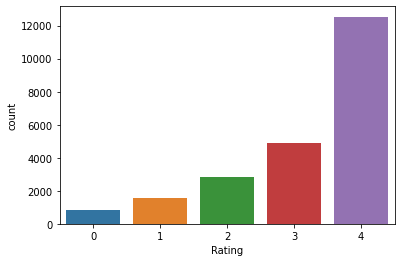

In [18]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
print(df_reviews['Rating'].value_counts())
sns.countplot(x='Rating', data=df_reviews)

In [19]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape   #CAMBIAR text_sequences POR reviews OALGO ASI

(22641,)

In [20]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [21]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [22]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [25]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [27]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [28]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens) # text_to_word_sequence ya hace la funcion de unique

1372203

In [30]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [31]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [35]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)
sequences[0][:10] # Para secuencia max de 10 palabras

[253, 532, 917, 3, 662, 3, 68]

In [36]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [38]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [39]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [42]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la máxima
# cantidad de palabras definidas para el vocabulario (vocab_size)
#y = df_reviews['Raiting'].values
y = to_categorical(df_reviews['Rating'])
print(y.shape)

(22641, 5)


Se puede verificar como las rows son iguales a la cantidad de rows del corpus y las columnas coinciden con la clasificaciónes de las reviews, 5.

In [54]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # multicategorical classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [63]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [75]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 115, 100)          200100    
_________________________________________________________________
lstm_6 (LSTM)                (None, 115, 64)           42240     
_________________________________________________________________
dropout_6 (Dropout)          (None, 115, 64)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

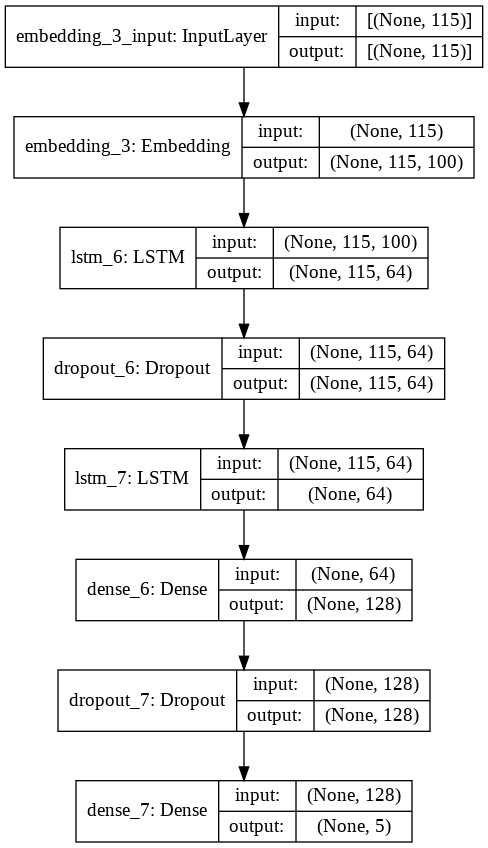

In [76]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
y_train.shape

(18112, 5)

In [78]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 30s 60ms/step - loss: 0.3894 - accuracy: 0.5594 - val_loss: 0.3365 - val_accuracy: 0.5976
Epoch 2/50
453/453 [==============================] - 26s 58ms/step - loss: 0.3182 - accuracy: 0.6125 - val_loss: 0.3143 - val_accuracy: 0.6150
Epoch 3/50
453/453 [==============================] - 26s 58ms/step - loss: 0.2952 - accuracy: 0.6399 - val_loss: 0.3126 - val_accuracy: 0.6139
Epoch 4/50
453/453 [==============================] - 26s 58ms/step - loss: 0.2807 - accuracy: 0.6575 - val_loss: 0.3123 - val_accuracy: 0.6158
Epoch 5/50
453/453 [==============================] - 26s 58ms/step - loss: 0.2686 - accuracy: 0.6720 - val_loss: 0.3205 - val_accuracy: 0.6249
Epoch 6/50
453/453 [==============================] - 26s 58ms/step - loss: 0.2557 - accuracy: 0.6840 - val_loss: 0.3160 - val_accuracy: 0.6285
Epoch 7/50
453/453 [==============================] - 26s 57ms/step - loss: 0.2453 - accuracy: 0.7046 - val_loss: 0.3246 - val_accuracy:

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

### Caso 1:
Parámetros utilizados:
* 10 Epochs
* Embeddings de tamaño 50

Resultados:
- Valdation Loss: 0.35026976466178894
- Accuracy: 0.6197836399078369

In [73]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 19ms/step - loss: 0.3503 - accuracy: 0.6198


[0.35026976466178894, 0.6197836399078369]

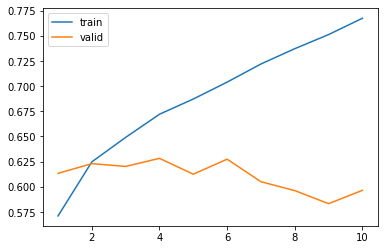

In [74]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### Caso 2:
Parámetros utilizados:
* 50 Epochs
* Embeddings de tamaño 100

Resultados:
- Valdation Loss: 1.0381869077682495
- Accuracy: 0.5842349529266357



In [79]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 19ms/step - loss: 1.0382 - accuracy: 0.5842


[1.0381869077682495, 0.5842349529266357]

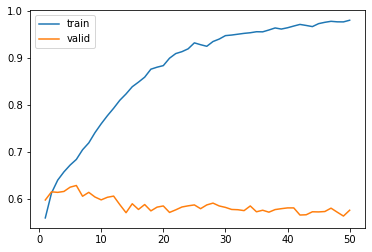

In [80]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

## **Conclusiones**
Podemos preciar como al aumentar el tamaño de los embeddings y principalmente la cantidad de epoch, el entrenamiento logra mayor accuracy, a costa de aumentar casi el triple el tiempo de entrenamiento.
Igualmente en ambos casos nos encontramos con mucho overfitting por lo que sería recomendable probar con un modelo más complejo.